In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from lmfit import Model

In [18]:
# Variables

F = 96485 # C/mol
col_dep = ['Time (s)', 'Potential vs Ag/AgCl (V)', 'Current (A)', 'Charge (C)']
col_cv = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Charge (C)', 'Time (s)', 'Current Density ($\mu$A/cm$^2$)', 'Scan']
col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li$^+$/Li (V)'] # 'Current Density (µA/cm$^2$)'
col2 = [col[3], 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)']
col_iv = ['Potential applied (V)', 'Current (A)', 'Time (s)']
col_tlm = ['Resistance ($\Omega$)', 'Spacing ($\mu$m)']
potentials = ['{:.2f}'.format(round(i, 4))  for i in np.arange(3.90, 4.20, 0.05)]
formatter_0 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e3))
formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))
formatter_2 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x / 1e6))

In [29]:
# TLM method

N = 100 # number of fingers
w = 10e-4 # cm
L = 0.5 # cm           5e3 um

def line(x, m, b):
        return x * m + b
    
def w_contact(s):
    w_s = (2 * N * (w + L + s)) - L - s
    return w_s.mean()
    
def tlm_model(s, r_s, l_t): # l_t
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)
    # return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm(path):
    file_list = [os.path.join(path, i) for i in os.listdir(path)]
    line_mod = Model(line)
    line_params = line_mod.make_params(m = 1, b = 1)
    tlm_mod = Model(tlm_model)
    tlm_params = tlm_mod.make_params(r_s = 1e4, l_t = 1)
    tlm_params['l_t'].set(value = 1, min = 0)
    
    values = pd.DataFrame(columns = col_tlm)
    
    n = 0
    for file in file_list:
        df = pd.read_csv(file, sep = ';', skiprows = 1, names = col_iv)
        result = line_mod.fit(df[col_iv[1]], line_params, x = df[col_iv[0]])
        r = 1 / result.values['m']
        spacing = float(file.split('S')[1][:2]) * 1e-4 #######################################
        values.loc[n] = (r, spacing)
        
        # print(file)
        n += 1
    print(values)
    
    
    result_tlm = tlm_mod.fit(values[col_tlm[0]], tlm_params, s = values[col_tlm[1]])
    print(result_tlm.fit_report())
  
    width_avg = w_contact(values[col_tlm[1]])
    rc = (tlm_mod.eval(result_tlm.params, s = 0)) / 2
    lt = result_tlm.values['l_t']
    sigma = (1 / result_tlm.values['r_s'] ) / (90e-7 * width_avg)
    p_c = rc * lt * width_avg
    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    print('LMO conductivity = ' + str(sigma))
    # contact_resistance = tlm_mod.eval(result_tlm.params, s = 0) / 2
    # print(result_tlm.params)
    
    fig, ax = plt.subplots(dpi = 200)
    # sns.scatterplot(data = values, x = col_tlm[1], y = col_tlm[0])
    sns.lineplot(data = values, x = col_tlm[1], y = col_tlm[0], linestyle = '', errorbar='sd', marker = 'o',err_style='bars')
    # sns.lineplot(x = values[col_tlm[1]], y = result_tlm.best_fit)
    sns.lineplot(x = np.array([-2e-4, 20e-4]), y = tlm_mod.eval(result_tlm.params, s = np.array([-2e-4, 20e-4])))
    ax.xaxis.set_major_formatter(formatter_1) # to show in um
    ax.yaxis.set_major_formatter(formatter_2)
    ax.set_ylabel('Resistance (M$\Omega$)')
    
    # plt.xlim(-5e-4, 23e-4)
    # plt.ylim(-1e5, 4.5e5)
    # plt.grid()
    # print('Contact Resistance ' + str(contact_resistance))
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line
    


    Resistance ($\Omega$)  Spacing ($\mu$m)
0            2.640655e+05            0.0002
1            6.090133e+05            0.0002
2            2.639912e+05            0.0002
3            1.913776e+05            0.0002
4            1.913895e+05            0.0002
5            6.091475e+05            0.0005
6            4.219583e+05            0.0005
7            8.239136e+05            0.0010
8            8.237143e+05            0.0010
9            1.503869e+06            0.0020
10           1.503869e+06            0.0020
11           1.503927e+06            0.0020
12           1.885522e+06            0.0020
13           1.882408e+06            0.0020
[[Model]]
    Model(tlm_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 414
    # data points      = 14
    # variables        = 2
    chi-square         = 3.2371e+11
    reduced chi-square = 2.6976e+10
    Akaike info crit   = 338.096872
    Bayesian info crit = 339.374986
    R-squared          = 0.93

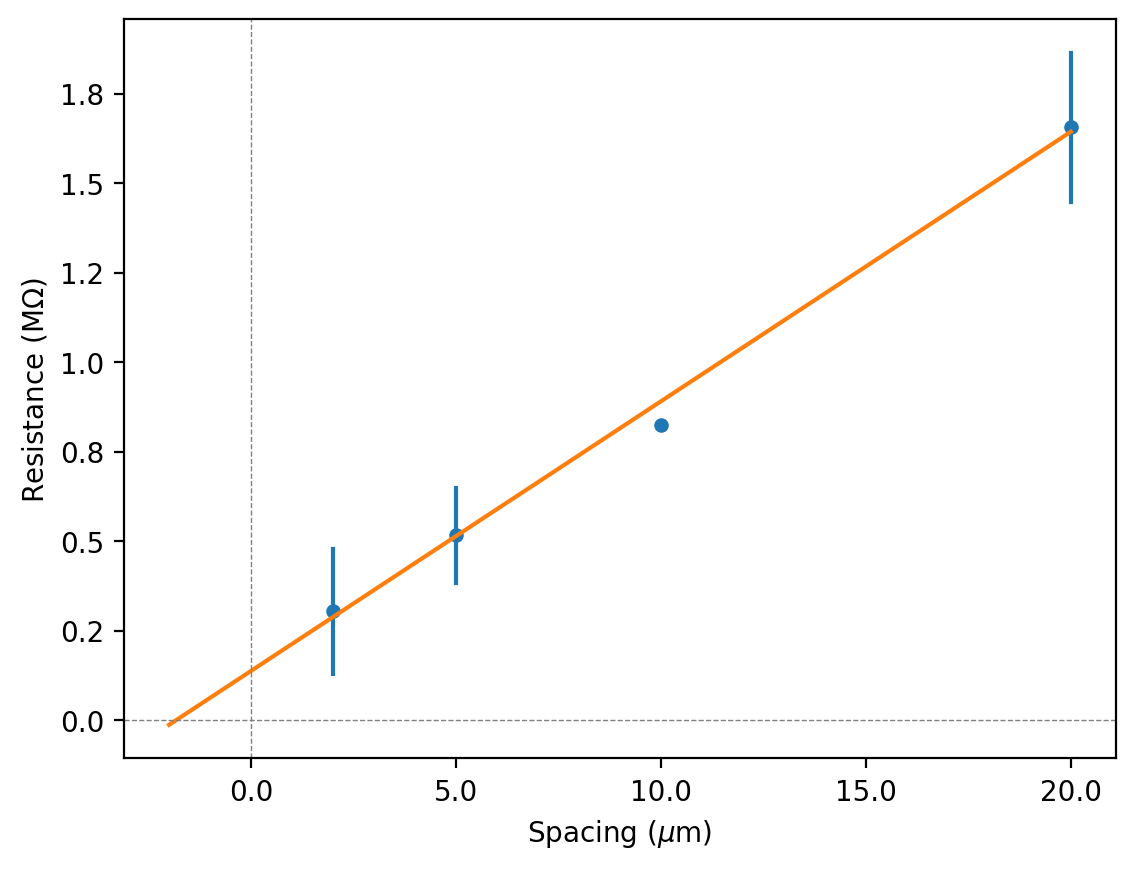

In [54]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA3_TLM\Pt on top\AUT'

pt = tlm(path)

In [ ]:
# old_measurements


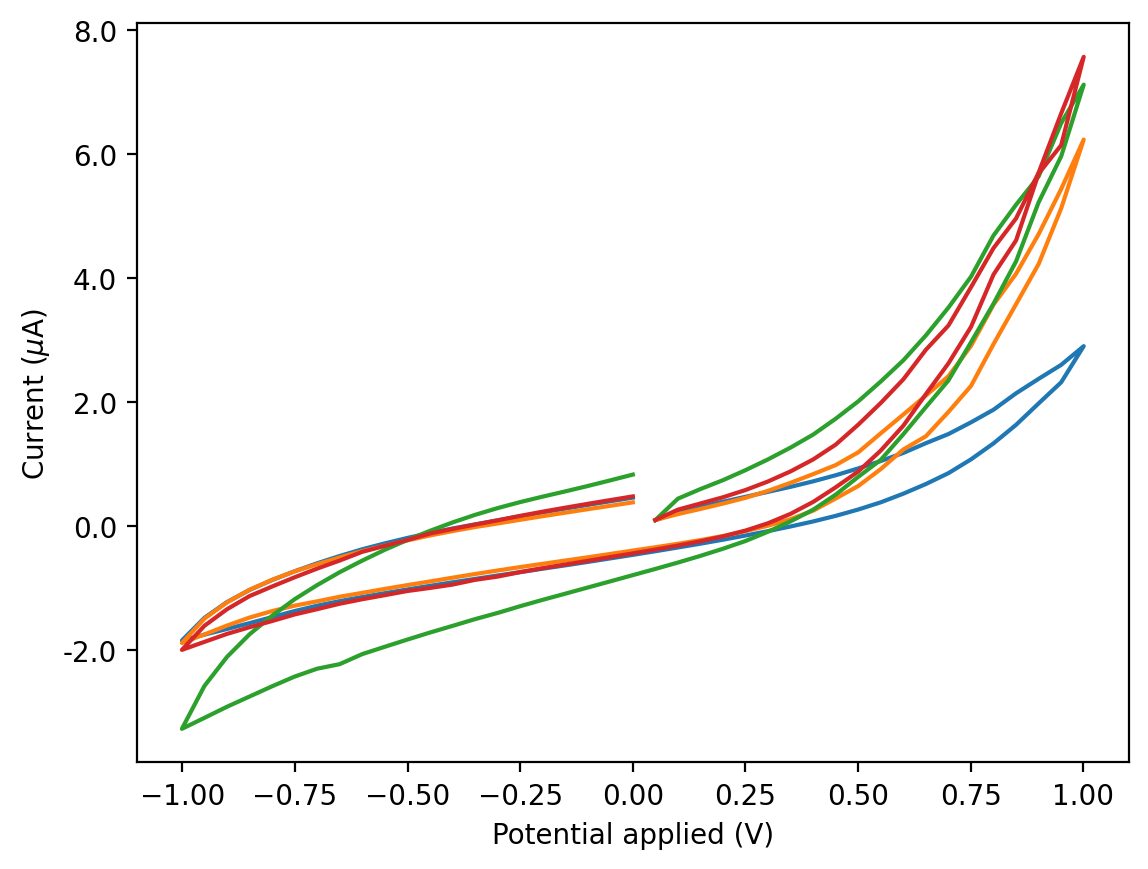

In [52]:
# Wet sample IV curves
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\TopLith\S20'
files = [os.path.join(path, i) for i in os.listdir(path) if i != '1C']

fig, ax = plt.subplots(dpi = 200)
ax.set_ylabel('Current ($\mu$A)')
ax.set_xlabel('Potential applied (V)')
ax.yaxis.set_major_formatter(formatter)

for i in files:
    df = pd.read_csv(i, sep = ';')
    plt.plot(df['Potential applied (V)'], df['WE(1).Current (A)'])